In [1]:
!pip list

Package                       Version            
----------------------------- -------------------
absl-py                       0.12.0             
alabaster                     0.7.12             
albumentations                0.1.12             
altair                        4.1.0              
appdirs                       1.4.4              
argon2-cffi                   20.1.0             
arviz                         0.11.2             
astor                         0.8.1              
astropy                       4.2.1              
astunparse                    1.6.3              
async-generator               1.10               
atari-py                      0.2.9              
atomicwrites                  1.4.0              
attrs                         21.2.0             
audioread                     2.1.9              
autograd                      1.3                
Babel                         2.9.1              
backcall                      0.2.0              


In [2]:
import os.path
import tensorflow as tf
import pickle as pkl
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.layers.merge import concatenate
from keras.optimizers import SGD
from matplotlib import pyplot as plt

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


In [4]:
no_classes = 10
img_width, img_height, img_num_channels = 32, 32, 3

In [5]:
(input_train, target_train), (input_test, target_test) = keras.datasets.cifar10.load_data()

In [6]:
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255


In [7]:
modelseq = Sequential()
modelseq.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
modelseq.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(MaxPooling2D((2, 2)))
modelseq.add(Dropout(0.2))
modelseq.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(MaxPooling2D((2, 2)))
modelseq.add(Dropout(0.2))
modelseq.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
modelseq.add(MaxPooling2D((2, 2)))
modelseq.add(Dropout(0.2))
modelseq.add(Flatten())
modelseq.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelseq.add(Dropout(0.2))
modelseq.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
modelseq.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize layers
print(modelseq.summary())
# plot graph
#plot_model(modelseq, to_file='modelseq.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               401536

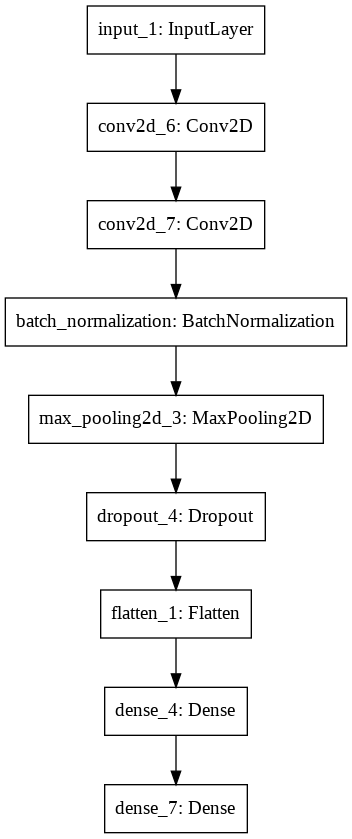

In [8]:
# input layer
visible = Input(shape=input_shape)
# first feature extractor
conv1 = Conv2D(32, (3,3), activation='relu')(visible)
conv1_2 = Conv2D(32, (3,3), activation='relu')(conv1)
batch1 = BatchNormalization()(conv1_2)
pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
drop1 = Dropout(0.2)(pool1)
flat1 = Flatten()(drop1)

# second feature extractor
conv2 = Conv2D(16, (3,3), activation='relu')(visible)
conv2_2 = Conv2D(16, (3,3), activation='relu')(conv2)
batch2 = BatchNormalization()(conv2_2)
pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
drop2 = Dropout(0.2)(pool2)
flat2 = Flatten()(drop2)

# third feature extractors 
conv3 = Conv2D(16, (3,3), activation='relu')(visible)
conv3_2 = Conv2D(16, (3,3), activation='relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_2)
drop3 = Dropout(0.2)(pool3)
flat3 = Flatten()(drop3)


# merge feature extractors
merge = concatenate([flat1, flat2])
merge2 = concatenate([flat1, flat3])
merge3 = concatenate([flat2, flat3])
# interpretation layer
hidden1 = Dense(128, activation='relu')(flat3)
hidden2 = Dense(128, activation='relu')(flat2)
hidden3 = Dense(128, activation='relu')(flat1)
# prediction output
output = Dense(no_classes, activation='softmax')(hidden1)
output2 = Dense(no_classes, activation='softmax')(hidden2)
output3 = Dense(no_classes, activation='softmax')(hidden3)

model2 = Model(inputs=visible, outputs=output)
model3 = Model(inputs=visible, outputs=output2)
model4 = Model(inputs=visible, outputs=output3)

opt = keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model4.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# summarize layers
print(model2.summary())
print(model3.summary())
print(model4.summary())
# plot graph
plot_model(model2, to_file='model2.png')
plot_model(model3, to_file='model3.png')
plot_model(model4, to_file='model4.png')

In [ ]:
# Fit data to model
history = modelseq.fit(input_train, target_train,
            batch_size=64,
            epochs=20,
            verbose=1,
            validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 316s 481ms/step - loss: 2.3647 - accuracy: 0.1354 - val_loss: 1.9275 - val_accuracy: 0.2896
Epoch 2/20
381/625 [=================>............] - ETA: 1:56 - loss: 1.9127 - accuracy: 0.2942

In [ ]:
history2 = model2.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_split=0.2)

In [ ]:
history3 = model3.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_split=0.2)

In [ ]:
history4 = model4.fit(input_train, target_train,
            batch_size=64,
            epochs=10,
            verbose=1,
            validation_split=0.2)

In [ ]:
# Generate generalization metrics
score = modelseq.evaluate(input_test, target_test, verbose=0)
score2 = model2.evaluate(input_test, target_test, verbose=0)
score3 = model3.evaluate(input_test, target_test, verbose=0)
score4 = model4.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')
print(f'Test loss: {score3[0]} / Test accuracy: {score3[1]}')
print(f'Test loss: {score4[0]} / Test accuracy: {score4[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['accuracy'],label = 'train_1')
plt.plot(history.history['val_accuracy'],label = 'test_1')
plt.plot(history2.history['accuracy'],label = 'train_2')
plt.plot(history2.history['val_accuracy'],label = 'test_2')
plt.plot(history3.history['accuracy'],label = 'train_3')
plt.plot(history3.history['val_accuracy'],label = 'test_3')
plt.plot(history4.history['accuracy'],label = 'train_4')
plt.plot(history4.history['val_accuracy'],label = 'test_4')
plt.legend()
plt.show()


In [ ]:
#print(input_test[1])
single = np.expand_dims(input_test[250], axis=0)
prediction1 = modelseq.predict(input_test)
prediction2 = model2.predict(input_test)
prediction3 = model3.predict(input_test)
prediction4 = model4.predict(input_test)

In [ ]:
#sum
predictsum = prediction2+prediction3+prediction4
#multiply with square of accuracy 
predictsum2 = score2[1]**2*prediction2+score3[1]**2*prediction3+score4[1]**2*prediction4

predictsum3 = prediction1+prediction2+prediction3+prediction4
predictsum4 = score[1]**2*prediction1+score2[1]**2*prediction2+score3[1]**2*prediction3+score4[1]**2*prediction4


In [ ]:
print(predictsum[2].sum())
print(target_test.shape)
print(np.mean(np.argmax(predictsum,axis=1)==np.squeeze(target_test)))
print(np.mean(np.argmax(predictsum2,axis=1)==np.squeeze(target_test)))
print(np.mean(np.argmax(predictsum3,axis=1)==np.squeeze(target_test)))
print(np.mean(np.argmax(predictsum4,axis=1)==np.squeeze(target_test)))